In [156]:
import uproot as ur
import matplotlib.pyplot as plt
import statistics
import k3d
import numpy as np
import awkward as ak

import matplotlib.colors as mcolors
from scipy.stats import norm
import scipy
from scipy.optimize import curve_fit
import mplhep as hep
import fastjet
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4)
hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [26]:
input_file = 'SimpleTree.root'
events = ur.open("%s:data"%(input_file))
arrays = events.arrays()

posx = arrays['Cal_hit_posx']
posy = arrays['Cal_hit_posy']
posz = arrays['Cal_hit_posz']
energy = arrays['Cal_hit_energy']

adcsum = arrays['Cal_adcsum']
detid = arrays['Cal_detid']


cut_primary = (arrays['Cal_hit_energy']>0) & ((arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))

xcut = posx[cut_primary]
ycut = posy[cut_primary]
zcut = posz[cut_primary]
adccut = adcsum[cut_primary]
ecut = energy[cut_primary]

In [125]:
allLorentz = []

hitPx = []
hitPy = []

for i in range(len(ecut)):
    eventLorentz = []
    evtPxN = []
    evtPyN = []
    for j in range(len(ecut[i])):
        normalized = np.sqrt(xcut[i][j]**2 + ycut[i][j]**2 + zcut[i][j]**2)
        e = ecut[i][j]
        px = (xcut[i][j] / normalized) * e
        py = (ycut[i][j] / normalized) * e
        pz = (zcut[i][j] / normalized) * e
        evtPxN.append(px / e)
        evtPyN.append(py / e)
        ex = abs(px)
        lorentz = {"px": px, "py": py, "pz": pz, "E": e, "ex": ex}
        eventLorentz.append(lorentz)
    allLorentz.append(eventLorentz)
    hitPx.append(evtPxN)
    hitPy.append(evtPyN)


In [109]:
cluster = fastjet.ClusterSequence(ak.Array(allLorentz), jetdef)
inc_jets = cluster.inclusive_jets()
jetE = []
jetX = []
jetY = []
jetEta = []

jetXNorm = []
jetYNorm = []

for elem in inc_jets:
    xnorm = []
    ynorm = []
    for i in range(len(elem.E)):
        #print("px:", elem.px[i],"py:", elem.py[i],"pz:", elem.pz[i],"E:", elem.E[i],)
        jetE.append(elem.E[i])
        jetX.append(elem.px[i])
        jetY.append(elem.py[i])
        xnorm.append(elem.px[i] / elem.E[i])
        ynorm.append(elem.py[i] / elem.E[i])
        theta = abs(np.arctan(elem.py[i] / elem.px[i]))
        jetEta.append(-1*np.log(np.tan(theta/2)))
    jetXNorm.append(xnorm)
    jetYNorm.append(ynorm)

In [83]:
eAllEvts = []
xAllEvts = []
yAllEvts = []
zAllEvts = []

eSum = []

for i in range(len(ecut)):
    energySum = 0
    xNormEvt = []
    yNormEvt = []
    for j in range(len(ecut[i])):     
        eAllEvts.append(adccut[i][j])
        xAllEvts.append(xcut[i][j])
        yAllEvts.append(ycut[i][j])
        zAllEvts.append(zcut[i][j])
        
        
        energySum += ecut[i][j]

    eSum.append(energySum)

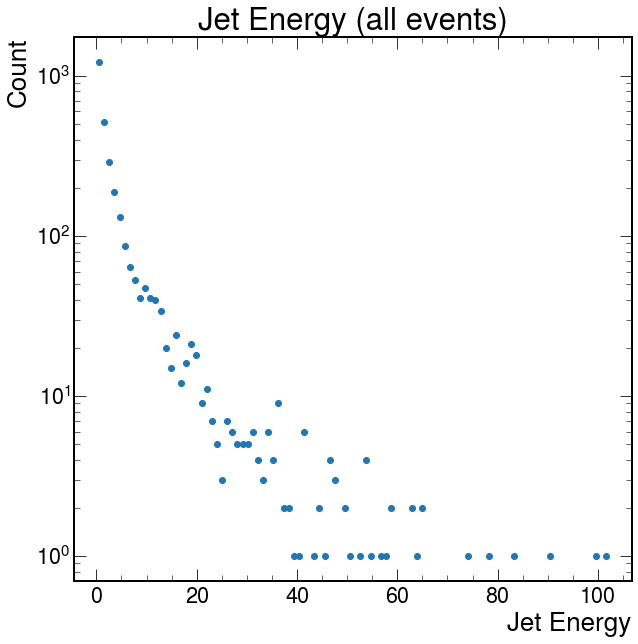

In [32]:
hist, bin_edges = np.histogram(jetE,bins=100)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

#Plot hit time histogram
plt.scatter(bin_centres,hist)
plt.yscale('log')
plt.xlabel('Jet Energy')
plt.ylabel('Count')
plt.title("Jet Energy (all events)")
plt.show()

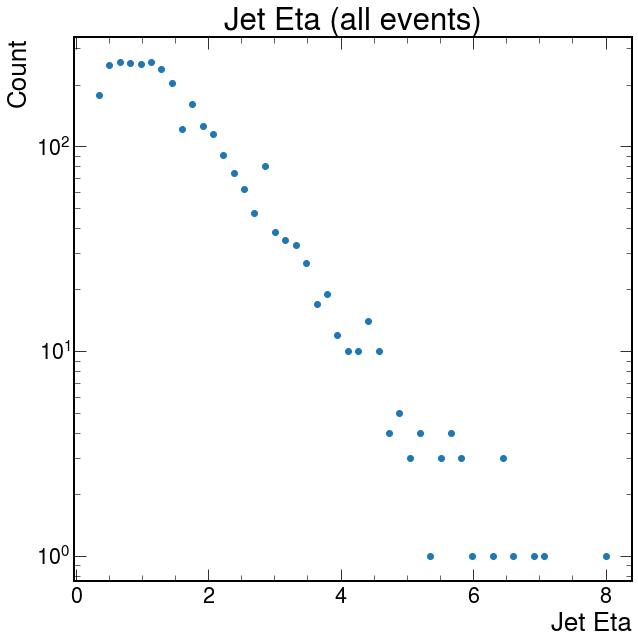

In [40]:
hist, bin_edges = np.histogram(jetEta,bins=50)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

#Plot hit time histogram
plt.scatter(bin_centres,hist)
plt.yscale('log')
plt.xlabel('Jet Eta')
plt.ylabel('Count')
plt.title("Jet Eta (all events)")
plt.show()

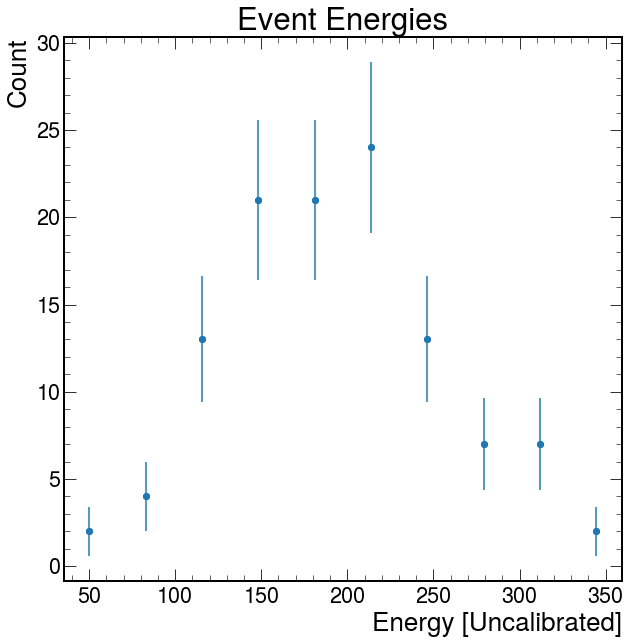

114


In [52]:
hist, bin_edges = np.histogram(eSum,bins=10)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

#Plot hit time histogram
plt.scatter(bin_centres,hist)
plt.errorbar(bin_centres, hist, yerr=np.sqrt(hist), fmt="o")
#plt.yscale('log')
plt.xlabel('Energy [Uncalibrated]')
plt.ylabel('Count')
plt.title("Event Energies")
plt.show()
print(len(eSum))

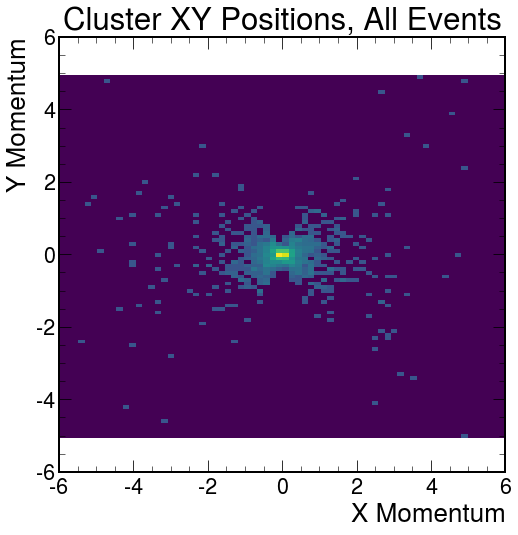

In [162]:
#Plot X Y hit distribution
fig = plt.figure( figsize=(8, 8))
plt.hist2d(jetX,jetY,bins=100,norm=mcolors.PowerNorm(0.2))
plt.title('Cluster XY Positions, All Events')
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.xlabel("X Momentum")
plt.ylabel("Y Momentum")

plt.show()

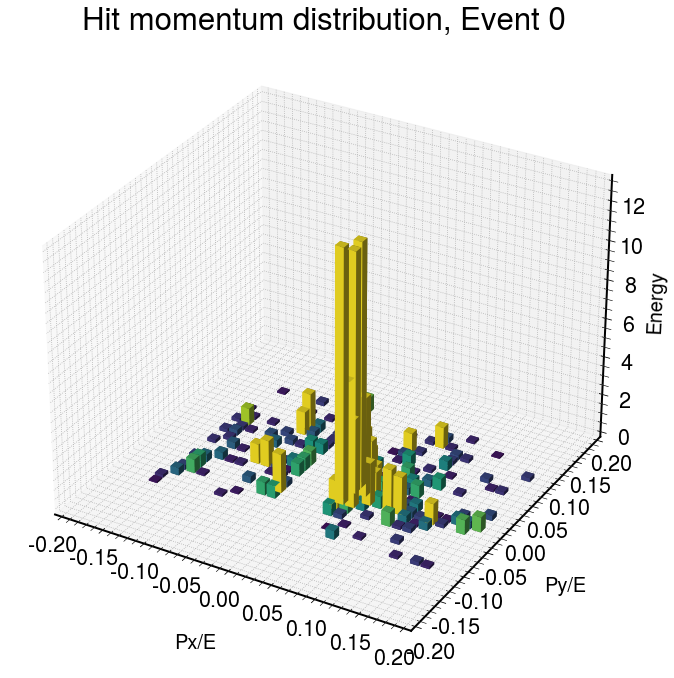

In [165]:
fig = plt.figure()
ax = plt.axes(projection="3d")
inferno =  plt.get_cmap('viridis')
i=0
cmap = plt.get_cmap('viridis')

ax.bar3d(np.array(hitPx[i]),np.array(hitPy[i]),0,0.01,0.01,np.array(ecut[i]),color=[cmap(k) for k in np.array(ecut[i])])

plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)
ax.set_xlabel('Px/E', fontsize=20)
ax.set_ylabel('Py/E', fontsize=20)
ax.set_zlabel('Energy', fontsize=20)

ax.yaxis.labelpad=30
ax.xaxis.labelpad=30
ax.zaxis.labelpad=10
plt.title("Hit momentum distribution, Event 0")
plt.tight_layout()

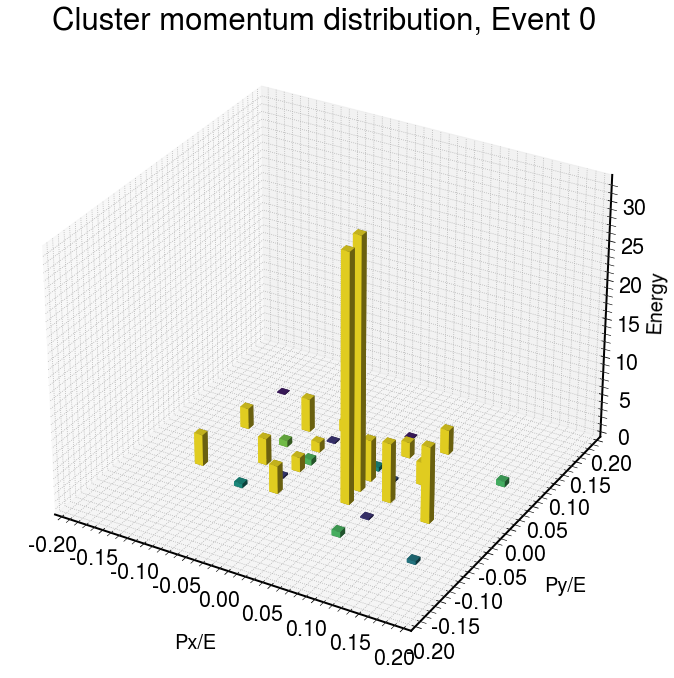

In [166]:
fig = plt.figure()
ax = plt.axes(projection="3d")
inferno =  plt.get_cmap('viridis')
i=0
cmap = plt.get_cmap('viridis')

ax.bar3d(np.array(jetXNorm[i]),np.array(jetYNorm[i]),0,0.01,0.01,np.array(inc_jets[i].E),color=[cmap(k) for k in np.array(inc_jets[i].E)])

plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)

ax.set_xlabel('Px/E', fontsize=20)
ax.set_ylabel('Py/E', fontsize=20)
ax.set_zlabel('Energy', fontsize=20)

ax.yaxis.labelpad=30
ax.xaxis.labelpad=30
ax.zaxis.labelpad=10
plt.title("Cluster momentum distribution, Event 0")
plt.tight_layout()